## Amazon Co-Purchasing Network Cliques

The goal of this notebook is to identify cliques within 2006 Amazon book co-purchasing data.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
import random
import time
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

### Get the Data
Read in a dictionary with ASIN IDs as keys and product titles as values

In [2]:
file_name = "Data/ID_map-11-18"
picklefile = open(file_name,'rb')
ID_map = pickle.load(picklefile)

# Function for getting the name based on an ASIN ID:
def get_product_name(ASIN):
    if ASIN in ID_map:
        return ID_map[ASIN]
    else:
        print("There was an error with %s", ASIN)

Read in adjacency matrix saved as a pickle file

In [3]:
file_name = "Data/copurchases-11-20"
picklefile = open(file_name,'rb')
copurchases = pickle.load(picklefile)

In the network, nodes represent products, and edges represent whether two products are commonly purchased together. There are a total of 548,552 nodes and 1,788,725 edges, which corresponds to an edge-to-node ratio of 3.26.

First, we make sure that `copurchases` is undirected.

In [4]:
print(len(copurchases))
for node in copurchases.copy().keys():
    for adjacent_nodes in copurchases[node]:
        try:
            assert node in copurchases[adjacent_nodes]
        except:
            if adjacent_nodes in copurchases:
                if isinstance(copurchases[adjacent_nodes], str):
                    copurchases[adjacent_nodes] = [copurchases[adjacent_nodes], node]
                else:
                    copurchases[adjacent_nodes].append(node)
            else:
                copurchases[adjacent_nodes] = [node]
print(len(copurchases))

548551
721342


After making the graph undirected, we have 721,342 nodes and 1,545,237 edges, giving an edge-to-node ratio of 2.14.

Class for Reporter object that stores cliques, and can print them

In [5]:
class Reporter(object):
    def __init__(self, name):
        self.name = name
        self.cnt = 0
        self.cliques = []

    def inc_count(self):
        self.cnt += 1

    def record(self, clique):
        self.cliques.append(clique)

    def sort_cliques(self):
        self.cliques.sort(key=len, reverse=True)

    def print_max(self, n):
        '''
        Prints the n largest cliques
        '''
        self.sort_cliques()
        print(self.name)
        print('%d recursive calls' % self.cnt)
        for i in range(n):
            clique = self.cliques[i]
            products = []
            for ASIN in clique:
                products.append(get_product_name(ASIN))
            print('%d: %s' % (i, products))
        print()

    def print_report(self):
        print(self.name)
        print('%d recursive calls' % self.cnt)
        for i, clique in enumerate(self.cliques):
            products = []
            for ASIN in clique:
                products.append(get_product_name(ASIN))
            print('%d: %s' % (i, products))
        print()
        
    def get_cliques(self):
        self.sort_cliques()
        return self.cliques
    
    def remove_duplicates(self):
        self.sort_cliques()
        seen = set()
        unique = []
        for clique in self.cliques:
            srtd = tuple(sorted(clique))
            if srtd not in seen:
                unique.append(clique)
                seen.add(srtd)
            else:
                print(clique)
        return unique

### Naive BK Algorithm

We implement the naive Bron–Kerbosch algorithm, which uses recursive backtracking to find the maximal cliques in an undirected graph. It works by keeping track of three sets:
- `clique`: the set of vertices that make up a potential maximal clique
- `candidates`: the set of vertices that could be in a maximal clique
- `excluded`: the set of vertices that have been examined already

In [6]:
def bronKerbosch1(clique, candidates, excluded, reporter, graph):
    '''Naive Bron–Kerbosch algorithm'''
    reporter.inc_count()
    if not candidates and not excluded:
        if len(clique) >= 3:
            reporter.record(clique)
        return
    
    for v in list(candidates):
        new_candidates = candidates.intersection(graph[v])
        new_excluded = excluded.intersection(graph[v])
        bronKerbosch1(clique+[v], new_candidates, new_excluded, reporter, graph)
        candidates.remove(v)
        excluded.add(v)

Let's start with a simple example to make sure the algorithm works. We expect two maximal cliques: [1,2,3] and [2,3,4,5].

In [7]:
graph = {1:[2,3], 2:[1,3,5,4], 3:[1,2,4,5], 4:[2,3,5], 5:[2,3,4]}
report0 = Reporter('## %s' % bronKerbosch1.__doc__)
bronKerbosch1([], set(graph.keys()), set(), report0, graph)
report0.get_cliques()

[[2, 3, 4, 5], [1, 2, 3]]

We got the maximal cliques that we expected to get! Now let's apply it to the Amazon data.

In [8]:
start = time.time()
report1 = Reporter('## %s' % bronKerbosch1.__doc__)
bronKerbosch1([], set(copurchases.keys()), set(), report1, copurchases)
end = time.time()
print('Naive method:', end - start) # in seconds

Naive method: 11.40553617477417


Print the 10 maximal cliques with the most elements

In [9]:
report1.print_max(10)

## Naive Bron–Kerbosch algorithm
3838452 recursive calls
0: ['III', 'The Eyes of Stanley Pain', 'Microscopic', "Charlie's Family", 'Furnace', 'Effector', 'Sidewinder']
1: ['Mandragore', 'Druuna X', 'Carnivora: Carnivora', 'Serpieri the Sweet Smell of Woman', 'Aphrodisia', 'Creatura', 'Serpieri Obsession']
2: ['A Song Flung Up to Heaven', "Wouldn't Take Nothing for My Journey Now", "Singin' and Swingin' and Gettin' Merry Like Christmas", 'Gather Together in My Name', 'The Heart of a Woman', 'Even the Stars Look Lonesome', "All God's Children Need Traveling Shoes"]
3: ['Spine: 100 Top Diagnoses (Pocketradiologist)', 'Pocket Radiologist Chest: Top 100 Diagnosis', 'Abdominal: Top 100 Diagnoses (Pocketradiologist)', 'PocketRadiologist: Brain Top 100 Diagnoses', 'PocketRadiologist: Head and Neck Top 100 Diagnoses', 'Pocketradiologist Pediatrics 100 Top Diagnoses', 'PocketRadiologist: Musculoskeletal Top 100 Diagnoses']
4: ['Craft Lessons: Teaching Writing K-8', 'Live Writing : Breathing Life

The maximum clique has 6 elements. These products are all pretty similar to each other. They would make good recommendations.

Now we will find the number of maximal cliques that have 7 vertices.

In [10]:
cliques1 = report1.get_cliques()
cliques1_max = [x for x in cliques1 if len(x) > 6]
print(len(cliques1_max))

48


### BK Algorithm with Pivoting

Now, we implement Bron–Kerbosch algorithm with pivoting. Randomly pick a vertex u from `candidates` or `excluded`. The maximal clique must include either u or one of its non-neighbors.

In [11]:
def bronKerbosch2(clique, candidates, excluded, reporter, graph):
    '''Bron–Kerbosch algorithm with pivot'''
    reporter.inc_count()
    if not candidates and not excluded:
        if len(clique) >= 3:
            reporter.record(clique)
        return
    
    u = pick_pivot(candidates.union(excluded))
    for v in list(candidates.difference(graph[u])):
        new_candidates = candidates.intersection(graph[v])
        new_excluded = excluded.intersection(graph[v])
        bronKerbosch2(clique+[v], new_candidates, new_excluded, reporter, graph)
        candidates.remove(v)
        excluded.add(v)
        
def pick_pivot(nodes):
    if nodes:
        elem = nodes.pop()
        nodes.add(elem)
        return elem

Let's start with the simple example again to make sure the algorithm works. We expect two maximal cliques: [1,2,3] and [2,3,4,5].

In [12]:
report0_pivot = Reporter('## %s' % bronKerbosch2.__doc__)
bronKerbosch2([], set(graph.keys()), set(), report0_pivot, graph)
report0_pivot.get_cliques()

[[4, 2, 3, 5], [1, 2, 3]]

We got the maximal cliques that we expected to get! Now let's apply it to the Amazon data.

In [13]:
start = time.time()
report1_pivot = Reporter('## %s' % bronKerbosch2.__doc__)
bronKerbosch2([], set(copurchases.keys()), set(), report1_pivot, copurchases)
end = time.time()
print('Pivot method:', end - start) # in seconds

Pivot method: 10.647101402282715


Print the 10 maximal cliques with the most elements and the number of maximal cliques that have 7 vertices.

In [14]:
report1_pivot.print_max(10)

## Bron–Kerbosch algorithm with pivot
2676547 recursive calls
0: ['III', 'The Eyes of Stanley Pain', 'Microscopic', "Charlie's Family", 'Furnace', 'Effector', 'Sidewinder']
1: ['Mandragore', 'Druuna X', 'Carnivora: Carnivora', 'Aphrodisia', 'Serpieri the Sweet Smell of Woman', 'Creatura', 'Serpieri Obsession']
2: ['A Song Flung Up to Heaven', 'Even the Stars Look Lonesome', "Singin' and Swingin' and Gettin' Merry Like Christmas", 'Gather Together in My Name', 'The Heart of a Woman', "Wouldn't Take Nothing for My Journey Now", "All God's Children Need Traveling Shoes"]
3: ['Spine: 100 Top Diagnoses (Pocketradiologist)', 'Pocket Radiologist Chest: Top 100 Diagnosis', 'Pocketradiologist Pediatrics 100 Top Diagnoses', 'PocketRadiologist: Brain Top 100 Diagnoses', 'PocketRadiologist: Head and Neck Top 100 Diagnoses', 'Abdominal: Top 100 Diagnoses (Pocketradiologist)', 'PocketRadiologist: Musculoskeletal Top 100 Diagnoses']
4: ['Craft Lessons: Teaching Writing K-8', 'Live Writing : Breathing

In [15]:
cliques1_pivot = report1_pivot.get_cliques()
cliques1_pivot_max = [x for x in cliques1_pivot if len(x) > 6]
print(len(cliques1_pivot_max))

48


We got the same results, and it took a shorter time to run (10.6 vs. 11.4 seconds).

### Visualizations
We will visualize our network. Since our network has many nodes, we will just visualize the first 1000 nodes. Each node is colored based on its degree. Lighter colors correspond to higher degrees.

First get the first 1000 nodes and remove all other connections and nodes

In [16]:
num_nodes = 1000

sub_copurchases = {}
nodes = set()
for key in copurchases:
    if len(nodes) == num_nodes:
        break
    nodes.add(key)
    sub_copurchases[key] = []
    for v in copurchases[key]:
        if len(nodes) == num_nodes:
            break
        nodes.add(v)
        sub_copurchases[key].append(v)

Make sure everything in `nodes` is a key in `sub_copurchases`

In [17]:
for node in nodes:
    if node not in sub_copurchases:
        sub_copurchases[node] = []
        try:
            for v in copurchases[node]:
                if v in nodes:
                    sub_copurchases[node].append(v)
        except:
            continue

Visualize `sub_copurchases`

In [18]:
G_sub_copurchases = nx.DiGraph()
G_sub_copurchases.add_nodes_from(sub_copurchases.keys())
for k, v in sub_copurchases.items():
    for t in v:
        if not G_sub_copurchases.has_edge(k, t) and not G_sub_copurchases.has_edge(t, k):
            G_sub_copurchases.add_edges_from(([(k, t)]))
print(nx.info(G_sub_copurchases))

Name: 
Type: DiGraph
Number of nodes: 1000
Number of edges: 1731
Average in degree:   1.7310
Average out degree:   1.7310


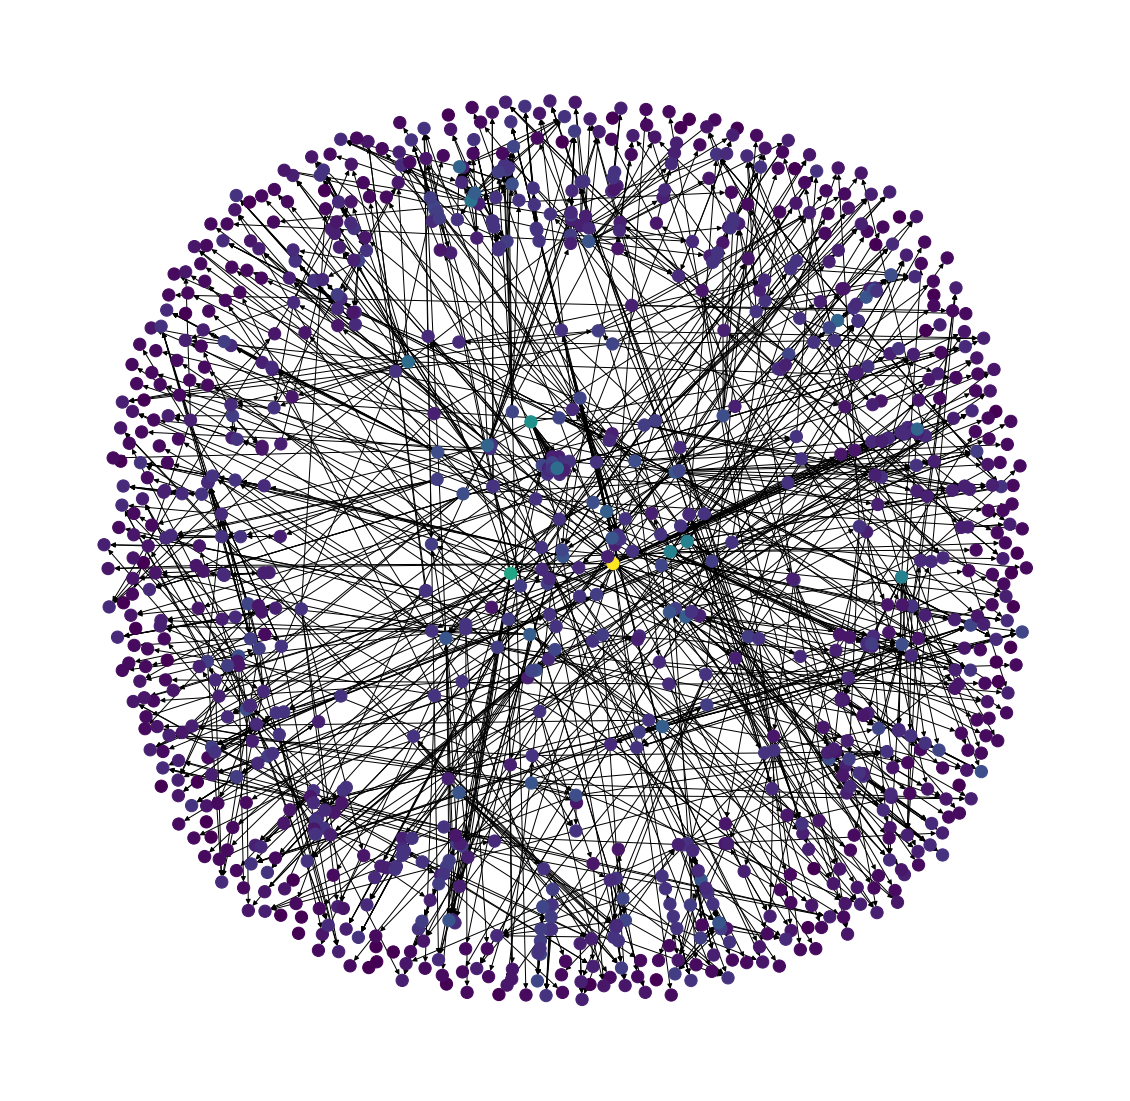

In [19]:
pos = nx.spring_layout(G_sub_copurchases)
node_color = [2000.0 * G_sub_copurchases.degree(v) for v in G_sub_copurchases]
plt.figure(figsize=(20,20))
_ = nx.draw_networkx(G_sub_copurchases, pos=pos, with_labels=False,
                 node_color=node_color, node_size=150)
_ = plt.axis('off')

Display degree colorbar

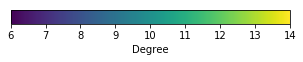

In [33]:
min_color = min(node_color)/2000
max_color = max(node_color)/2000

fig, ax = plt.subplots(figsize=(5, 0.5))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=min_color, vmax=max_color)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

cb1.set_label('Degree')
fig.show()

### NetworkX
In this section, we will use `NetworkX`'s functions to double check our maximal cliques and find k-cores, which are a type of relaxed cliques where every vertex in the subgraph has a degree >= k.

In [21]:
G_copurchases = nx.DiGraph()
G_copurchases.add_nodes_from(copurchases.keys())
for k, v in copurchases.items():
    for t in v:
        if not G_copurchases.has_edge(k, t) and not G_copurchases.has_edge(t, k):
            G_copurchases.add_edges_from(([(k, t)]))
G_copurchases = G_copurchases.to_undirected()
print(nx.info(G_copurchases))

Name: 
Type: Graph
Number of nodes: 721342
Number of edges: 1545237
Average degree:   4.2843


In [22]:
cliques_networkx = list(nx.find_cliques(G_copurchases))

In [23]:
def print_max(cliques, n):
    '''
    Prints the n largest cliques
    '''
    cliques.sort(key=len, reverse=True)
    for i in range(n):
        clique = cliques[i]
        products = []
        for ASIN in clique:
            products.append(get_product_name(ASIN))
        print('%d: %s' % (i, products))
    print()

In [24]:
print_max(cliques_networkx, 10)

0: ['III', 'The Eyes of Stanley Pain', "Charlie's Family", 'Microscopic', 'Effector', 'Furnace', 'Sidewinder']
1: ['Mandragore', 'Druuna X', 'Carnivora: Carnivora', 'Serpieri the Sweet Smell of Woman', 'Serpieri Obsession', 'Creatura', 'Aphrodisia']
2: ['A Song Flung Up to Heaven', "Wouldn't Take Nothing for My Journey Now", 'Gather Together in My Name', "All God's Children Need Traveling Shoes", "Singin' and Swingin' and Gettin' Merry Like Christmas", 'The Heart of a Woman', 'Even the Stars Look Lonesome']
3: ['Spine: 100 Top Diagnoses (Pocketradiologist)', 'Pocket Radiologist Chest: Top 100 Diagnosis', 'Abdominal: Top 100 Diagnoses (Pocketradiologist)', 'PocketRadiologist: Brain Top 100 Diagnoses', 'Pocketradiologist Pediatrics 100 Top Diagnoses', 'PocketRadiologist: Head and Neck Top 100 Diagnoses', 'PocketRadiologist: Musculoskeletal Top 100 Diagnoses']
4: ['Craft Lessons: Teaching Writing K-8', "A Writer's Notebook: Unlocking the Writer within You", 'Live Writing : Breathing Life 

In [25]:
cliques_networkx_max = [x for x in cliques_networkx if len(x) > 6]
print(len(cliques_networkx_max))

48


These results agree with our results from the naive and pivoting BK algorithms.

Next, we will find k-cores in which every vertex has a degree of at least 7, 6, and 5.

In [26]:
seven_core = nx.k_core(G_copurchases, k=7)
six_core = nx.k_core(G_copurchases, k=6)
five_core = nx.k_core(G_copurchases, k=5)

In [27]:
print(nx.info(seven_core))

Name: 
Type: Graph
Number of nodes: 0
Number of edges: 0



In [28]:
print(nx.info(six_core))

Name: 
Type: Graph
Number of nodes: 865
Number of edges: 2945
Average degree:   6.8092


In [29]:
print(nx.info(five_core))

Name: 
Type: Graph
Number of nodes: 141050
Number of edges: 519936
Average degree:   7.3724


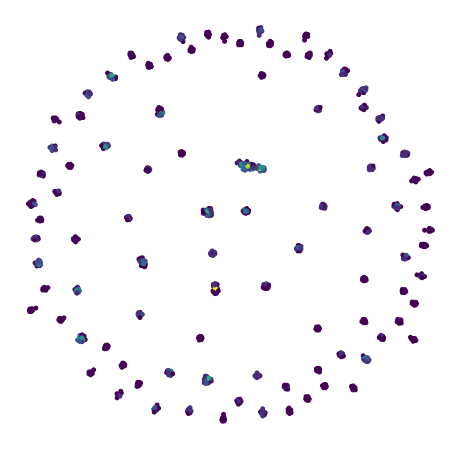

In [30]:
pos = nx.spring_layout(six_core)
node_color = [2000.0 * six_core.degree(v) for v in six_core]
plt.figure(figsize=(8,8))
_ = nx.draw_networkx(six_core, pos=pos, with_labels=False,
                 node_color=node_color, node_size=15)
_ = plt.axis('off')

As expected, a 7-core does not exist because our maximal clique has degrees of 6. A 6-core exists with 865 nodes, and a 5-core exists with 141050 nodes. Visualizing the 6-core shows clusters of products that may be potential sources of recommendations.